In [209]:
import	cv2 as cv
import	matplotlib.pyplot as plt
import	numpy as np
import	os
import	sys
import	math
from	skimage.morphology import skeletonize
# Library from utkarsh, Peter Kovesi
# School of Computer Science & Software Engineering
# The University of Western Australia
from	lib import image_enhance

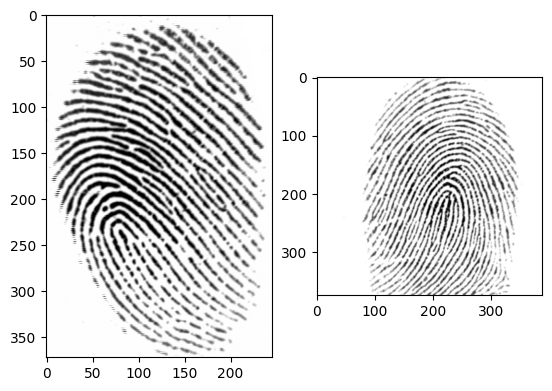

In [210]:
sample = cv.imread("../db/101_1.tif", cv.IMREAD_GRAYSCALE)
to_match = cv.imread("../db/102_2.tif", cv.IMREAD_GRAYSCALE)

# Image 1
plt.subplot(1, 2, 1)
plt.imshow(sample, cmap="gray")

# Image 2
plt.subplot(1, 2, 2)
plt.imshow(to_match, cmap="gray")

In [211]:
# Remove unwanted
def removedot(invertThin):
	temp0 = np.array(invertThin[:])
	temp0 = np.array(temp0)
	temp1 = temp0 / 255
	temp2 = np.array(temp1)
	temp3 = np.array(temp2)

	enhanced_img = np.array(temp0)
	filter0 = np.zeros((10,10))
	W, H = temp0.shape[:2]
	filtersize = 6

	for i in range(W - filtersize):
		for j in range(H - filtersize):
			filter0 = temp1[i:i + filtersize,j:j + filtersize]

			flag = 0
			if sum(filter0[:,0]) == 0:
				flag +=1
			if sum(filter0[:,filtersize - 1]) == 0:
				flag +=1
			if sum(filter0[0,:]) == 0:
				flag +=1
			if sum(filter0[filtersize - 1,:]) == 0:
				flag +=1
			if flag > 3:
				temp2[i:i + filtersize, j:j + filtersize] = np.zeros((filtersize, filtersize))

	return temp2

In [212]:
def get_descriptors(img):
	clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	img = clahe.apply(img)
	img = image_enhance.image_enhance(img)
	
	plt.subplot(2, 2, 1)
	plt.imshow(img, cmap="gray")

	img = np.array(img, dtype=np.uint8)
	
	# Threshold
	ret, img = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
	
	# Normalize to 0 and 1 range
	img[img == 255] = 1
	
	#Thinning
	skeleton = skeletonize(img)
	skeleton = np.array(skeleton, dtype=np.uint8)
	skeleton = removedot(skeleton)
	plt.subplot(2, 2, 2)
	plt.imshow(skeleton, cmap="gray")

	# Harris corners
	harris_corners = cv.cornerHarris(img, 3, 3, 0.04)
	harris_normalized = cv.normalize(harris_corners, 0, 255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32FC1)
	threshold_harris = 125

	plt.subplot(2, 2, 3)	
	plt.imshow(harris_normalized, cmap="gray")
	
	# Extract keypoints
	keypoints = []
	for x in range(0, harris_normalized.shape[0]):
		for y in range(0, harris_normalized.shape[1]):
			if harris_normalized[x][y] > threshold_harris:
				keypoints.append(cv.KeyPoint(y, x, 1))
	
	# Define descriptor
	orb = cv.ORB_create()
	
	# Compute descriptors
	_, des = orb.compute(img, keypoints)
	
	return (keypoints, des);

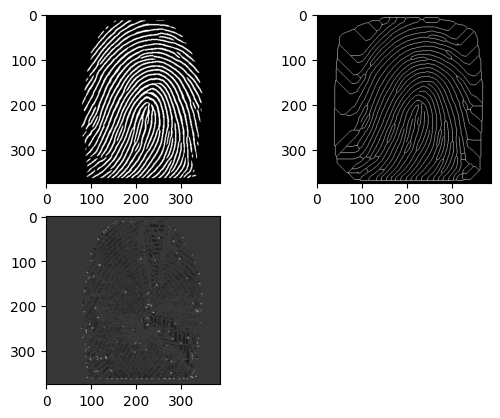

In [213]:
# find image descriptors
img1 = sample
kp1, des1 = get_descriptors(img1)
img2 = to_match
kp2, des2 = get_descriptors(img2)

# Matching between descriptors
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)

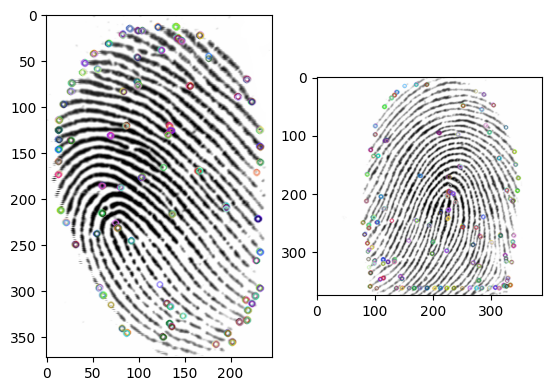

In [214]:
# Plot keypoints
img4 = cv.drawKeypoints(img1, kp1, outImage=None)
img5 = cv.drawKeypoints(img2, kp2, outImage=None)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img4)
axarr[1].imshow(img5)
plt.show()

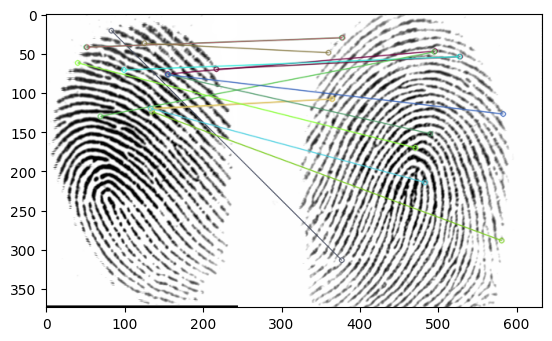

Fingerprint does not match.


In [215]:
# Plot matches
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, flags=2, outImg=None)
plt.imshow(img3)
plt.show()

# Calculate score
score = 0;
for match in matches:
	score += match.distance

score_threshold = 33
if len(matches) > 0 and score / len(matches) < score_threshold:
	print("Fingerprint matches.")
else:
	print("Fingerprint does not match.")